In [18]:
import gym
import seagul.envs
gym.make('su_acro_drake-v0')

import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PpoModel, switchedPpoModel, SwitchedPpoModelActHold
from seagul.nn import MLP
torch.set_default_dtype(torch.double)

#load_path = './data/mj_baseline7/acrobot73380899'
#load_path = './data/inv_pend/acrobot_116_3'

seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils
seagul.rl.run_utils


Text(0.5, 1.0, 'Reward curve')

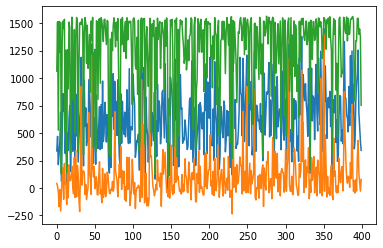

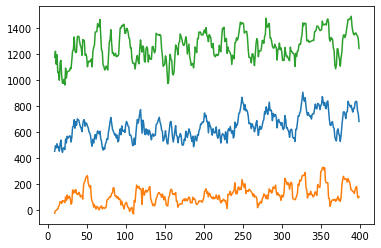

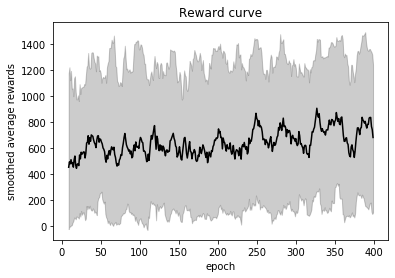

In [19]:
def control(env,q):
    k = array([[1316.85000612,  555.41763935,  570.32667002,  272.57631536]])
    goal = np.copy(env.state)
    goal[0] -= pi
    return -k.dot(goal)


seeds = [0,1,2,3]
load_paths = ['./data/drake_acro_switch6/400_nhb_se' + str(seed) for seed in seeds]
#load_paths = ['./data/acrobot/sg_b' + str(seed) for seed in seeds]
model, env, args, ws = load_workspace(load_paths[0])
num_steps = ws['num_epochs']


avg_rewards = np.zeros((num_steps,))
rewards = np.zeros((num_steps,4))

for i, load_path in enumerate(load_paths):
    model, env, args, ws = load_workspace(load_path)
    
    avg_rewards += np.array((ws['avg_reward_hist']))
    rewards[:,i] = np.array((ws['avg_reward_hist']))
    #append(ws['avg_reward_hist'])
    #plt.title('reward vs epoch')
    #plt.figure()
    #plt.plot(ws['a'])
    #plt.figure()
    #plt.plot(ws['p_loss_hist'])
    #plt.figure()
    #plt.plot(ws['v_loss_hist'])
    #print(ws['num_states'])
    
avg_rewards /= len(seeds)
min_rewards = [np.min(rewards[i,:]) for i in range(num_steps)]
max_rewards = [np.max(rewards[i,:]) for i in range(num_steps)]
plt.plot(avg_rewards)
plt.plot(min_rewards)
plt.plot(max_rewards)

rewards_smoothed = pd.Series(avg_rewards).rolling(10, min_periods=10).mean()
min_smoothed =  pd.Series(min_rewards).rolling(10, min_periods=10).mean()
max_smoothed =  pd.Series(max_rewards).rolling(10, min_periods=10).mean()

plt.figure()
plt.plot(rewards_smoothed)
plt.plot(min_smoothed)
plt.plot(max_smoothed)

plt.figure()

epochs = [t for t in range(num_steps)]
plt.plot(rewards_smoothed[1:1200], color='k')
plt.fill_between(epochs[1:1200], min_smoothed[1:1200], max_smoothed[1:1200], color='k',alpha=.2 )
plt.xlabel('epoch')
plt.ylabel('smoothed average rewards')
plt.title('Reward curve')

#plt.figure()
#plt.plot(np.array(ws['ep_path_tensor']))

In [15]:
from seagul.nn import DummyNet

# Acrobot
#load_path = './data/drake_acro4/seed7'
load_path = load_paths[2]
model, env, args, ws = load_workspace(load_path)

#model.policy = DummyNet(4,1, 0,0,0)
model.env = env
myenv = env
#myenv.num_steps=1000
#myenv.max_t = 5


#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
logp_hist = np.zeros((myenv.num_steps, 1))
gate_mean = np.zeros((myenv.num_steps,1))

#model.action_var = 0
#model.action_var = 1
#model.gate_var = 0

#model.action_var = 0
obs = myenv.reset()

for i in range(myenv.num_steps):
        actions, _, _, logp = model.step(obs)
        #actions = np.clip(actions, -700,700)
        gate_mean[i,:] = model.gate_fn(torch.as_tensor(obs)).detach().numpy()
        #actions = np.zeros(1)
        #actions = np.clip(actions,-10, 10)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        try:
            logp_hist[i,:]   = logp.detach()
        except:
            logp_hist[i,:]   = logp
            
        #env.render()
        if done:
            break
            
            

seagul.rl.run_utils
seagul.rl.run_utils


199
[148.19966543]


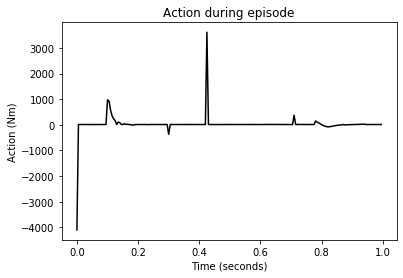

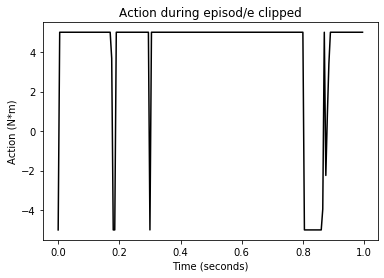

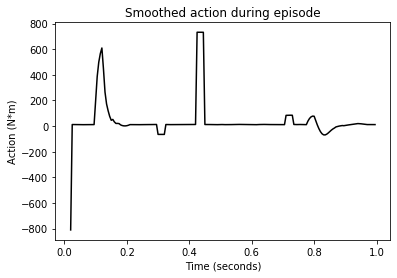

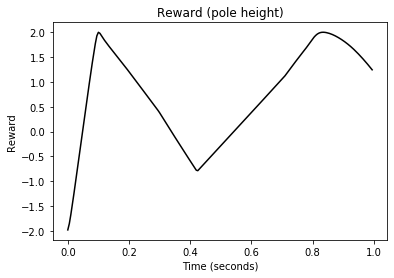

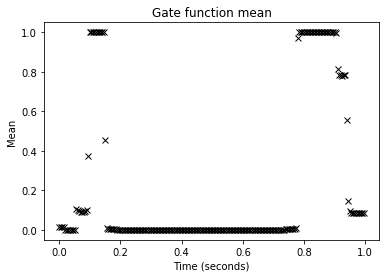

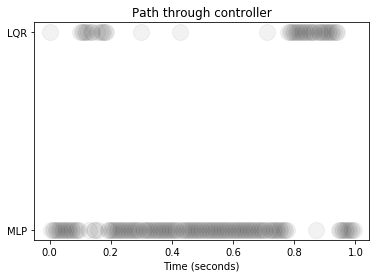

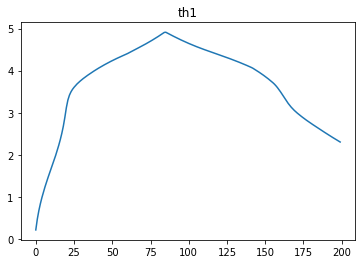

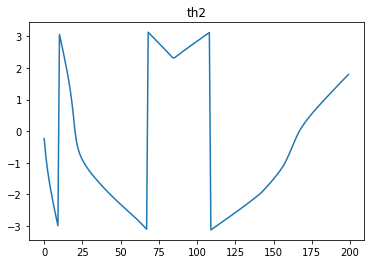

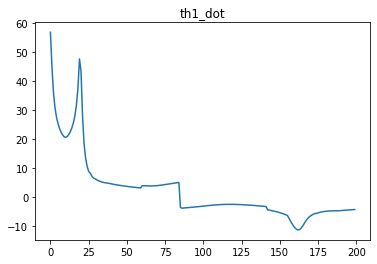

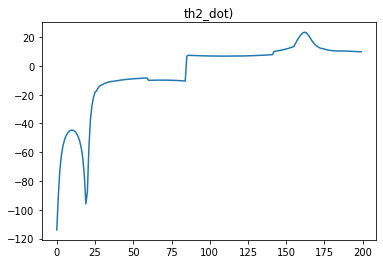

In [16]:
t_end = int(env.num_steps)

gate_hist = [1 if p == 0 else 0 for p in logp_hist]
t = [.005*i for i in range(myenv.num_steps)]
plt.plot(t[:t_end], action_hist[:t_end], color='k')
plt.title('Action during episode')
plt.xlabel('Time (seconds)')
plt.ylabel('Action (Nm)')

plt.figure()
plt.plot(t, np.clip(action_hist, -5,5), color='k')
plt.title('Action during episod/e clipped')
plt.xlabel('Time (seconds)')
plt.ylabel('Action (N*m)')

plt.figure()
actions_smoothed = pd.Series(action_hist.squeeze()).rolling(5, min_periods=5).mean()
plt.plot(t, actions_smoothed, color='k')
plt.title('Smoothed action during episode')
plt.xlabel('Time (seconds)')
plt.ylabel('Action (N*m)')


plt.figure()
plt.plot(t[:t_end], reward_hist[:t_end], color='k')
plt.title('Reward (pole height)')
plt.xlabel('Time (seconds)')
plt.ylabel('Reward')


plt.figure()
plt.plot(t[:t_end], gate_mean[:t_end] ,'x', color='k')
plt.title('Gate function mean')
#plt.yticks([0,1],['MLP', 'LQR'])
plt.xlabel('Time (seconds)')
plt.ylabel('Mean')


plt.figure()
plt.plot(t[:t_end], gate_hist[:t_end], 'o', color='k', alpha=.05,markersize=16)
plt.title('Path through controller')
plt.yticks([0,1],['MLP', 'LQR'])
plt.xlabel('Time (seconds)')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("th1")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("th2")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("th1_dot")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("th2_dot)")

print(i)
print(sum(reward_hist))

seagul.rl.run_utils
seagul.rl.run_utils


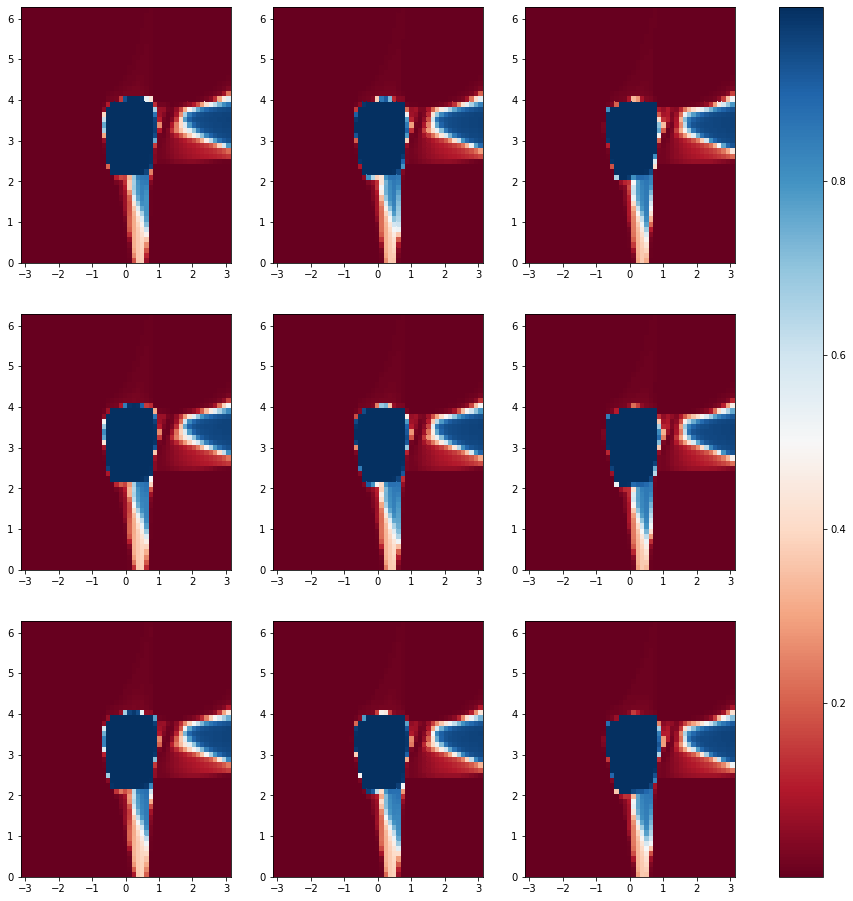

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos


#load_path = './data/drake_acro_switch/seed8'
load_path = load_paths[0]
model, env, args, ws = load_workspace(load_path)
#model, env, = load_model(load_path)



#model.gate_fn = torch.load('gate_fn_dr_small')
#model.policy = torch.load('warm_policy_dr')

n_thdot = 3
n_th = 50
fig, ax = plt.subplots(n_thdot,n_thdot, figsize=(16,16))

th1_vals = np.linspace(0,2*pi,n_th)
th2_vals = np.linspace(-pi,pi,n_th)

th1dot_vals = np.linspace(-10,10,n_thdot)
th2dot_vals = np.linspace(-30,30,n_thdot)

for th1i, th1dot in enumerate(th1dot_vals):
    for th2i, th2dot in enumerate(th2dot_vals):
       
        means = np.zeros((n_th,n_th))

        for i,th1 in enumerate(th1_vals):
            for j,th2 in enumerate(th2_vals):
                #obs = torch.tensor([cos(th1), sin(th1), cos(th2), sin(th2), th1dot,th2dot])
                obs = torch.tensor([th1, th2, th1dot, th2dot])
                means[i,j] = model.gate_fn(obs)



        # generate 2 2d grids for the x & y bounds
        y, x = np.meshgrid(th1_vals, th2_vals)
        z = means

        # x and y are bounds, so z should be the value *inside* those bounds.
        # Therefore, remove the last value from the z array.
        z = z[:-1, :-1]
        z_min, z_max = z.min(), z.max()


        c = ax[th1i, th2i].pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('pcolormesh')
        # set the limits of the plot to the limits of the data
        ax[th1i,th2i].axis([x.min(), x.max(), y.min(), y.max()])

        #plt.show()
        
#for i,a in enumerate(ax):
    #for j,b in enumerate(a):
        #b.set(ylabel = "theta 1", xlabel="theta 2", title="th2d=" + str(th2dot_vals[j]) +  "  th1d=" + str(th1dot_vals[i]) )
        #b.label_outer()
fig.colorbar(c, ax=ax)



Text(0.5, 1.0, 'Pretrained gate network output for $\\dot q_{1} = \\dot q_{2} = 0$')

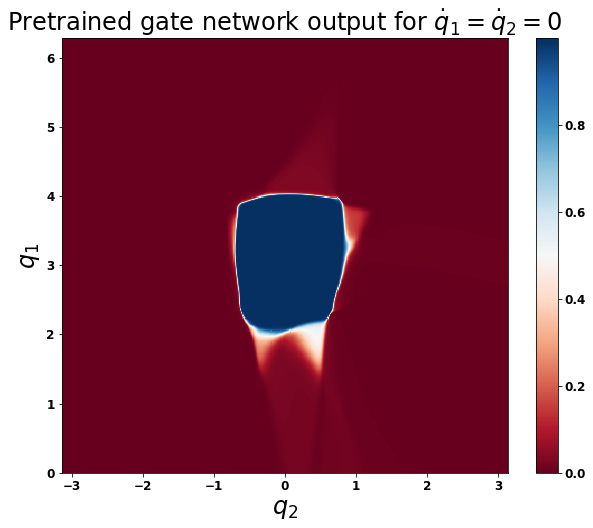

In [120]:
SMALL_SIZE = 12
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

matplotlib.rc('font', **font)

fig, ax = plt.subplots(n_thdot,n_thdot, figsize=(10,8))


y, x = np.meshgrid(th1_vals, th2_vals)
z = means

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = 0, np.abs(z).max()


c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
#ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
    
plt.xlabel(r'$q_{2}$')
plt.ylabel(r'$q_{1}$')
plt.title(r'Pretrained gate network output for $\dot q_{1} = \dot q_{2} = 0$')

seagul.rl.run_utils
seagul.rl.run_utils


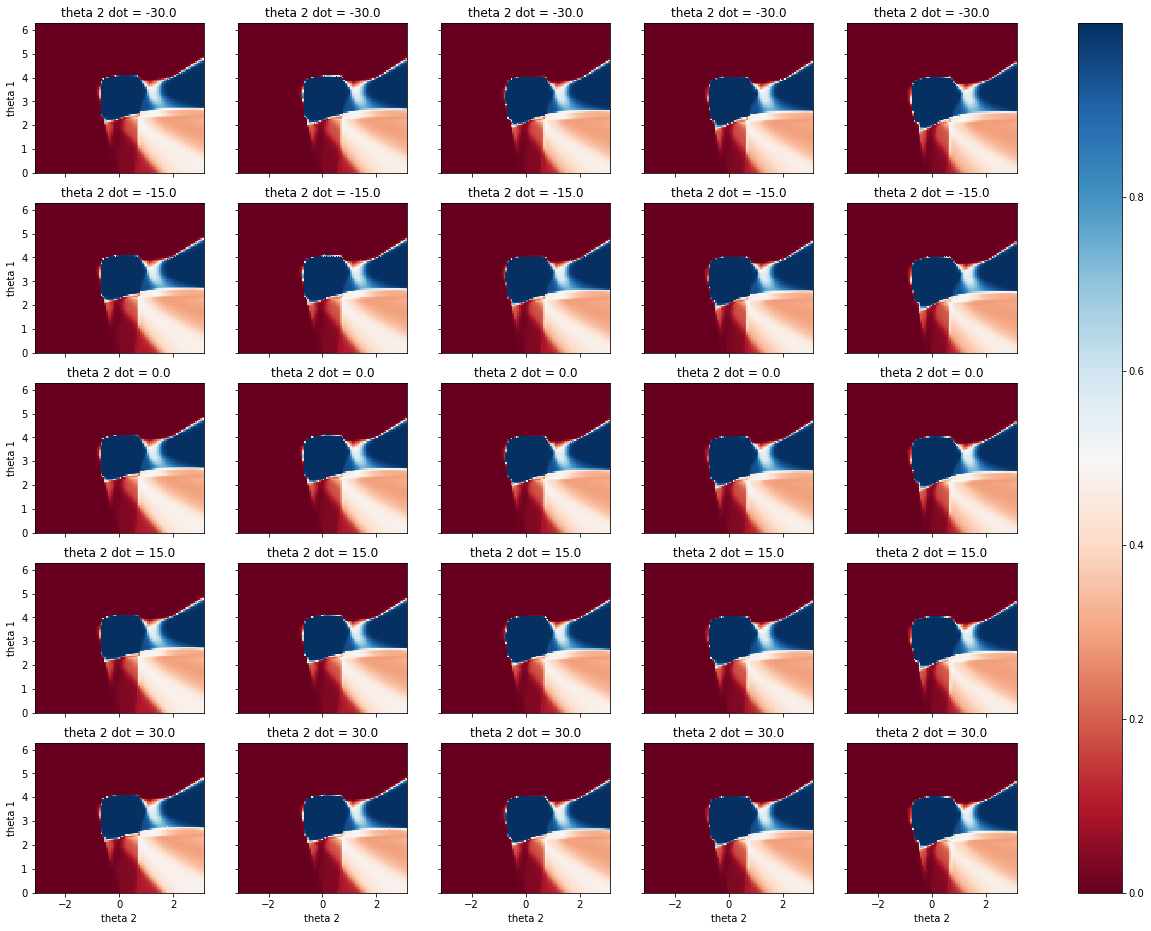

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos



load_path = './data/drake_acro4/5'
model, env, args, ws = load_workspace(load_path)


#model.gate_fn = torch.load("./gate_fn_drv")

n_thdot = 5
n_th = 100
fig, ax = plt.subplots(n_thdot,n_thdot, figsize=(22,16))

th1_vals = np.linspace(0,2*pi,n_th)
th2_vals = np.linspace(-pi,pi,n_th)

th1dot_vals = np.linspace(-10,10,n_thdot)
th2dot_vals = np.linspace(-30,30,n_thdot)

for th1i, th1dot in enumerate(th1dot_vals):
    for th2i, th2dot in enumerate(th2dot_vals):
       
        means = np.zeros((n_th,n_th))

        for i,th1 in enumerate(th1_vals):
            for j,th2 in enumerate(th2_vals):
                #obs = torch.tensor([cos(th1), sin(th1), cos(th2), sin(th2), th1dot,th2dot])
                obs = torch.tensor([th1, th2, th1dot, th2dot])
                means[i,j] = model.gate_fn(obs)



        # generate 2 2d grids for the x & y bounds
        y, x = np.meshgrid(th1_vals, th2_vals)
        z = means

        # x and y are bounds, so z should be the value *inside* those bounds.
        # Therefore, remove the last value from the z array.
        z = z[:-1, :-1]
        z_min, z_max = 0, np.abs(z).max()


        c = ax[th1i, th2i].pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        #ax.set_title('pcolormesh')
        # set the limits of the plot to the limits of the data
        ax[th1i, th2i].axis([x.min(), x.max(), y.min(), y.max()])

        #plt.show()
        
for i,a in enumerate(ax):
    for j,b in enumerate(a):
        b.set(ylabel = "theta 1", xlabel="theta 2", title="theta 2 dot = " + str(th2dot_vals[i]))
        b.label_outer()
        
fig.colorbar(c, ax=ax)


              

In [2]:
# Cartpole

myenv = env
myenv.num_steps=1500 

sss

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")


print(i)
print(sum(reward_hist))

NameError: name 'env' is not defined

seagul.rl.run_utils
seagul.rl.run_utils
[-1427.35497218]
[-1509.37843606]
[-1562.05991437]
[-1578.88537527]
[-1559.16598799]
[-1510.5526957]
[-1701.60294192]
[-1698.92177143]
[-1685.10010368]
[-1658.37015438]
[-1618.81884031]
[-1568.24651418]
[-1509.26408697]
[-1444.26232323]
[-1374.84720559]
[-1301.84712726]
[-1225.67827513]
[-1146.85134962]
[-1066.49347143]
[-986.77041062]
[-911.00843325]
[-843.27747428]
[-787.42134792]
[-745.99080214]
[-719.74746359]
[-707.97785481]
1999
[-1356.92050793]


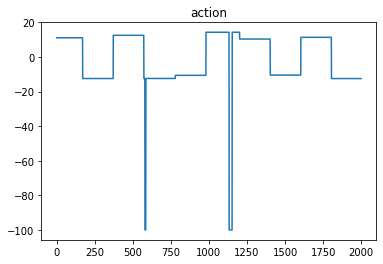

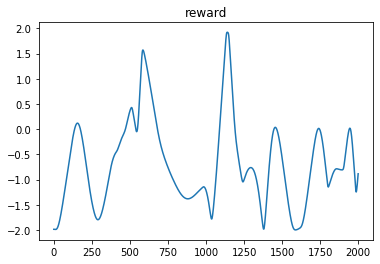

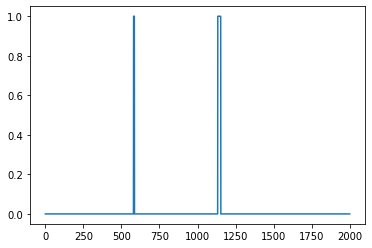

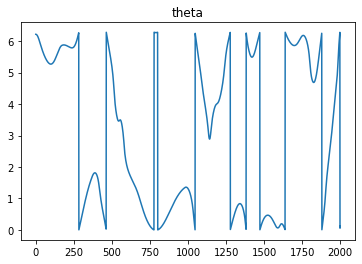

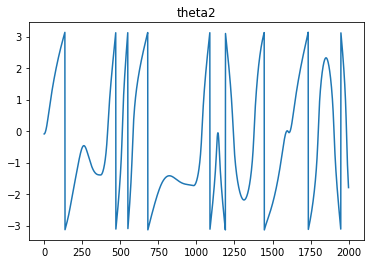

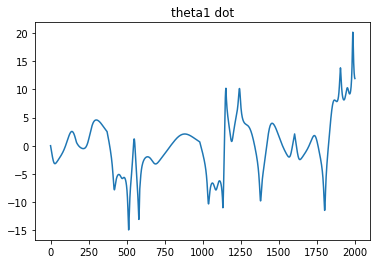

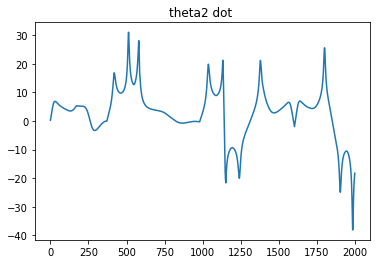

In [27]:
from seagul.rl.models import SwitchedPpoModelActHold,switchedPpoModel
from seagul.nn import MLP, CategoricalMLP
import torch
import torch.nn as nn

def control(q):
    k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

load_path = './data/drake_acro2/seed7'
model, env, args, ws  = load_workspace(load_path)


myenv = env
myenv.num_steps=2000
myenv.max_t = 10

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
path_hist = np.zeros((myenv.num_steps,1))

obs = env.reset()
#env.state[0] = np.pi
model.hyst_state = 0

for i in range(myenv.num_steps):
        if ((140 * pi/180 < obs[0] < 220 * pi/180) and (-40*pi/180 < obs[1] < 40 * pi/180)):
            actions = np.array(control(obs))*10
            print(actions)
            #actions = np.zeros(1)
            path_hist[i]  = 1
        
        else:
            actions, _, _, _ = model.step(obs)
            path_hist[i] = 0
            
        
        actions = np.clip(actions, -100, 100)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.title('action')

plt.figure()
plt.plot(reward_hist)
plt.title('reward')

plt.figure()
plt.plot(path_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("theta2")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta1 dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("theta2 dot ")

print(i)
print(sum(reward_hist))

In [15]:
# Pretty print the ws keys

pprint(list(ws.keys()))

['v_loss',
 'local_values',
 'v_epoch',
 'p_loss',
 'r',
 'old_logp',
 'logp',
 'local_adv',
 'local_actions',
 'local_states',
 'p_epoch',
 'training_generator',
 'training_data',
 'ep_adv',
 'deltas',
 'value_preds',
 'ep_length',
 'ep_disc_rewards',
 'ep_action_tensor',
 'ep_state_tensor',
 '_',
 'done',
 'reward',
 'state_np',
 'logprob',
 'action',
 't',
 'reward_list',
 'state_list',
 'action_list',
 'state',
 'action_tensor',
 'state_tensor',
 'disc_rewards_tensor',
 'adv_tensor',
 'traj_count',
 'traj_steps',
 'batch_steps',
 'episode_reward_sum',
 'epoch',
 'p_loss_hist',
 'v_loss_hist',
 'avg_reward_hist',
 'device',
 'use_cuda',
 'v_optimizer',
 'p_optimizer',
 'old_model',
 'num_states',
 'disc_rewards_std',
 'disc_rewards_mean',
 'state_var',
 'state_mean',
 'action_var_lookup',
 'sched_length',
 'obs_size',
 'action_dtype',
 'action_size',
 'reward_stop',
 'use_gpu',
 'v_epochs',
 'p_epochs',
 'value_lr',
 'policy_lr',
 'value_batch_size',
 'policy_batch_size',
 'seed',
 

In [ ]:
# SMoothed action plot

smooth_action = pd.Series(action_hist.reshape(-1)).rolling(10, min_periods=10).mean()
plt.plot(smooth_action, color='k')

In [ ]:
# if you want this will load the policy after warm starting but before training

def control(env,q):
    k = np.array([-1000, 1000, -10, -10])
    goal = np.copy(env.state)
    goal[0] -= pi
    return -k.dot(goal)

env = gym.make('su_acrobot-v0')
model = switchedPpoModel(
     #policy = MLP(input_size, output_size, num_layers, layer_size, activation),
     policy = torch.load("policy_warm"),
     value_fn = torch.load("value_fn_warm"),
     #MLP(input_size, 1, num_layers, layer_size, activation),
     gate_fn  = torch.load("gate_fn_ac"),
     nominal_policy=control,
     env=env
)